In [ ]:
# Step 1: Imports & Data Load
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Added RandomForestClassifier here

In [ ]:
print("\n1. DATA LOADING & INITIAL INSPECTION …………………………………………")

url = "https://drive.google.com/uc?export=download&id=1QBTnXxORRbJzE5Z2aqKHsVqgB7mqowiN"
df = pd.read_csv(url)
print(df.head(3))
print("Shape:", df.shape)


1. DATA LOADING & INITIAL INSPECTION …………………………………………
   VIN (1-10)  County     City State  Postal Code  Model Year   Make    Model  \
0  5YJ3E1EB6K    King  Seattle    WA      98178.0        2019  TESLA  MODEL 3   
1  5YJYGAEE5M  Yakima    Selah    WA      98942.0        2021  TESLA  MODEL Y   
2  5YJSA1E65N  Yakima  Granger    WA      98932.0        2022  TESLA  MODEL S   

            Electric Vehicle Type  \
0  Battery Electric Vehicle (BEV)   
1  Battery Electric Vehicle (BEV)   
2  Battery Electric Vehicle (BEV)   

   Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0            Clean Alternative Fuel Vehicle Eligible           220.0   
1  Eligibility unknown as battery range has not b...             0.0   
2  Eligibility unknown as battery range has not b...             0.0   

   Base MSRP  Legislative District  DOL Vehicle ID  \
0        0.0                  37.0       101250425   
1        0.0                  15.0       224162858   
2        0.0        

In [ ]:
# Check nulls
print(df.isna().sum())
# Fill object columns with mode, number columns with median
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

# Outlier removal (IQR method, numeric columns)
num_cols = df.select_dtypes(include=np.number).columns
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
mask = ~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[mask]

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
cat_cols = df.select_dtypes(include='object').columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # Save for later decoding if needed

print(df.head())

VIN (1-10)                                             0
County                                                 4
City                                                   4
State                                                  0
Postal Code                                            4
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                        17
Base MSRP                                             17
Legislative District                                 540
DOL Vehicle ID                                         0
Vehicle Location                                      11
Electric Utility                                       4
2020 Census Tract                                      4
dtype: int64
    VIN (1-10)  Co

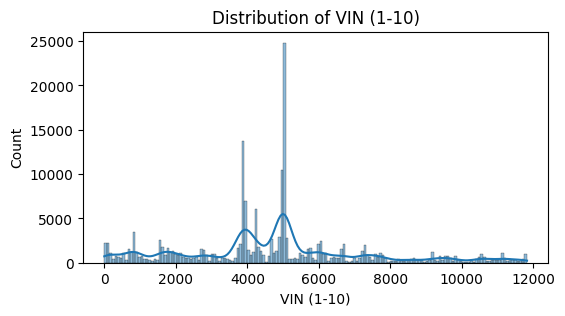

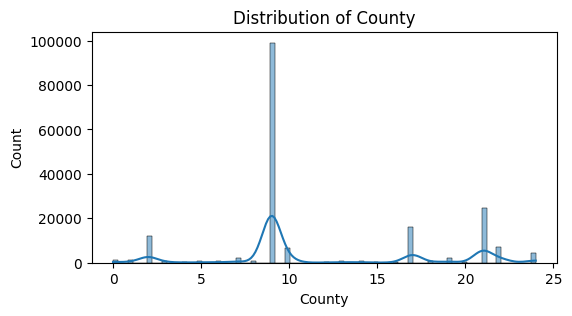

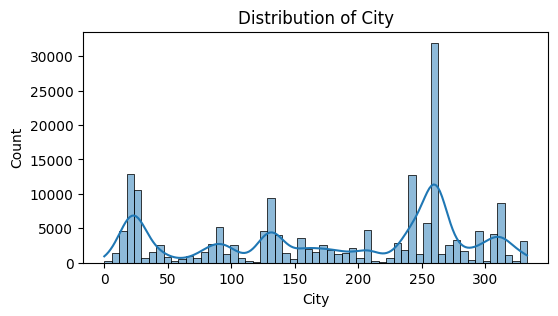

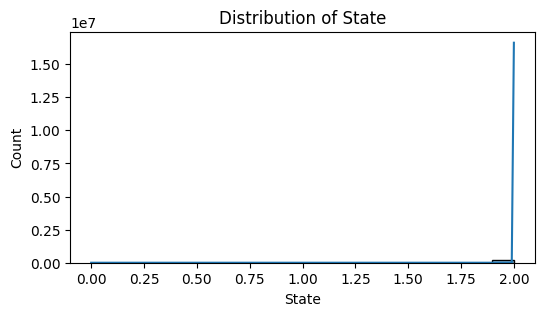

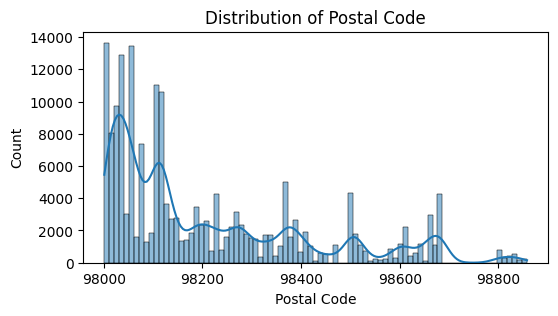

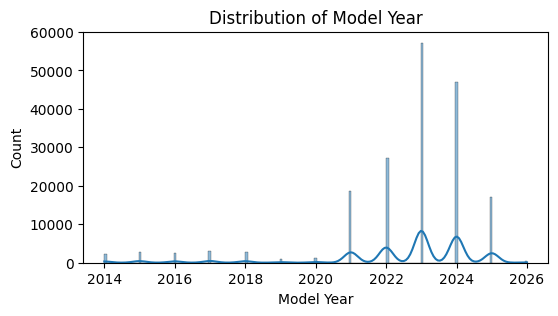

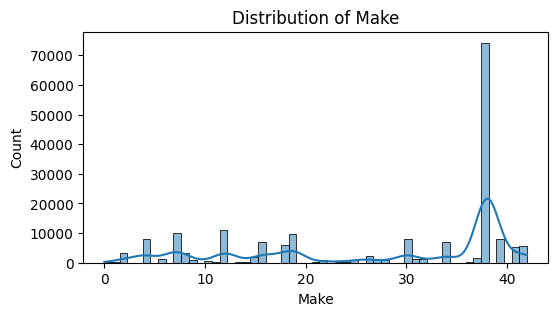

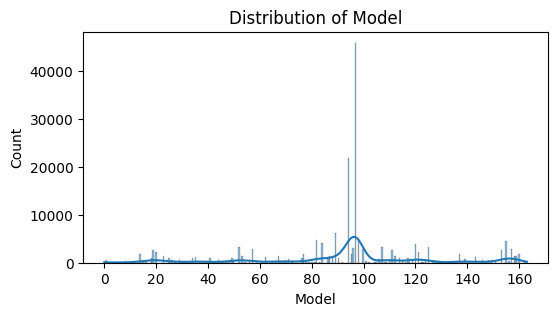

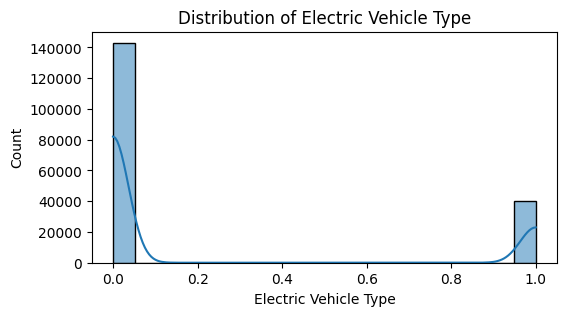

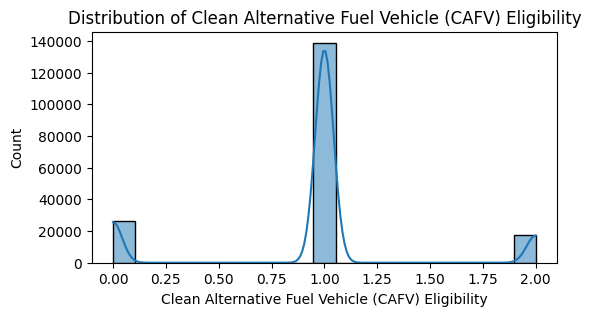

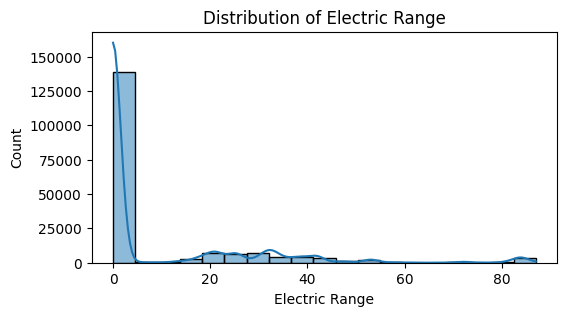

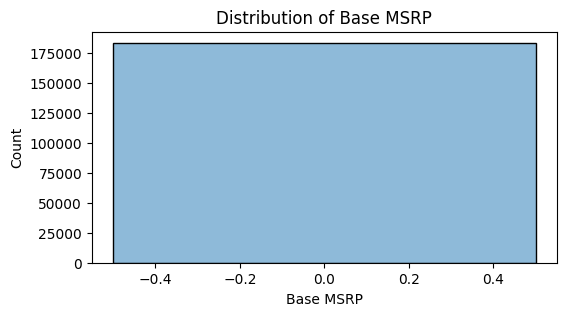

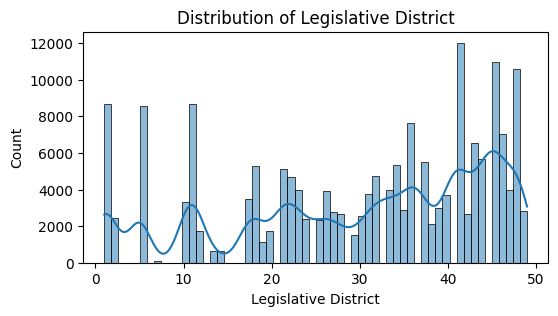

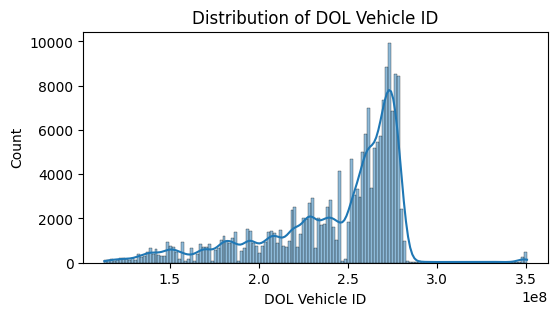

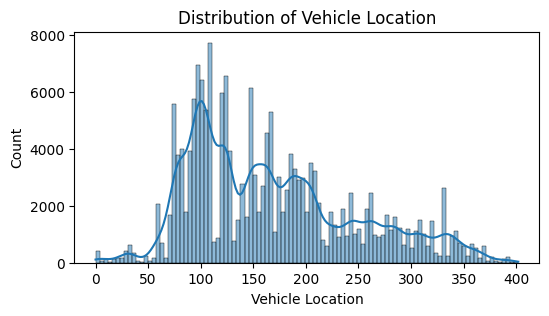

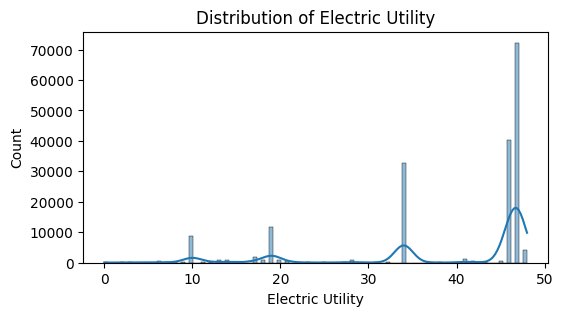

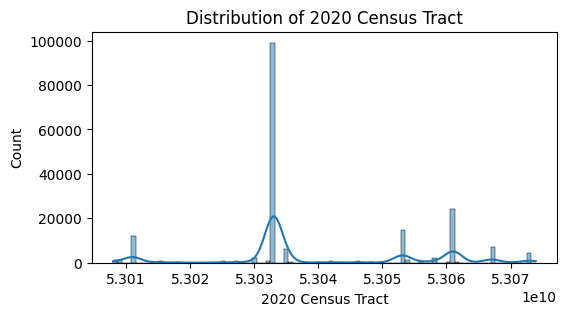

In [ ]:
# Univariate analysis: Numeric
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


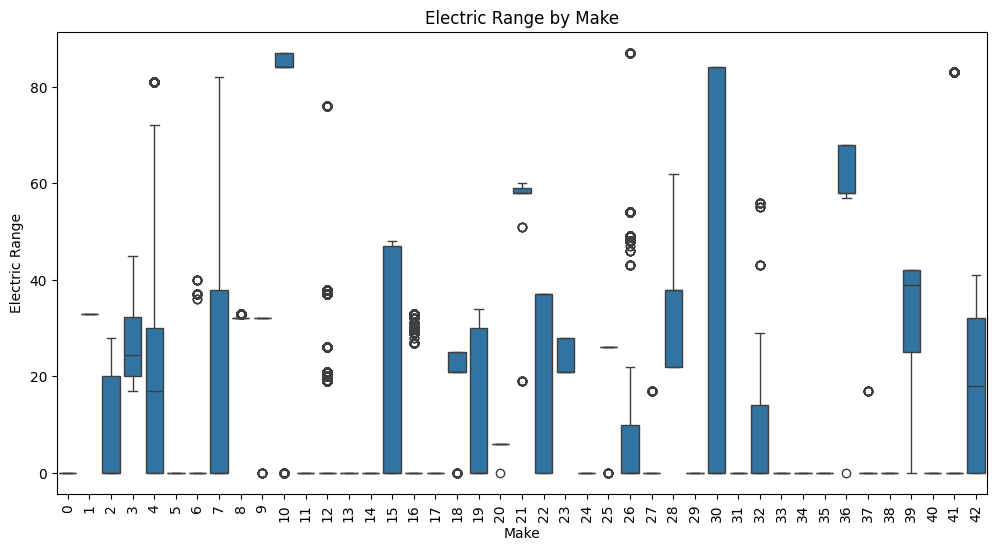

In [ ]:
if 'Make' in df.columns and 'Electric Range' in df.columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(x='Make', y='Electric Range', data=df)
    plt.xticks(rotation=90)
    plt.title('Electric Range by Make')
    plt.show()

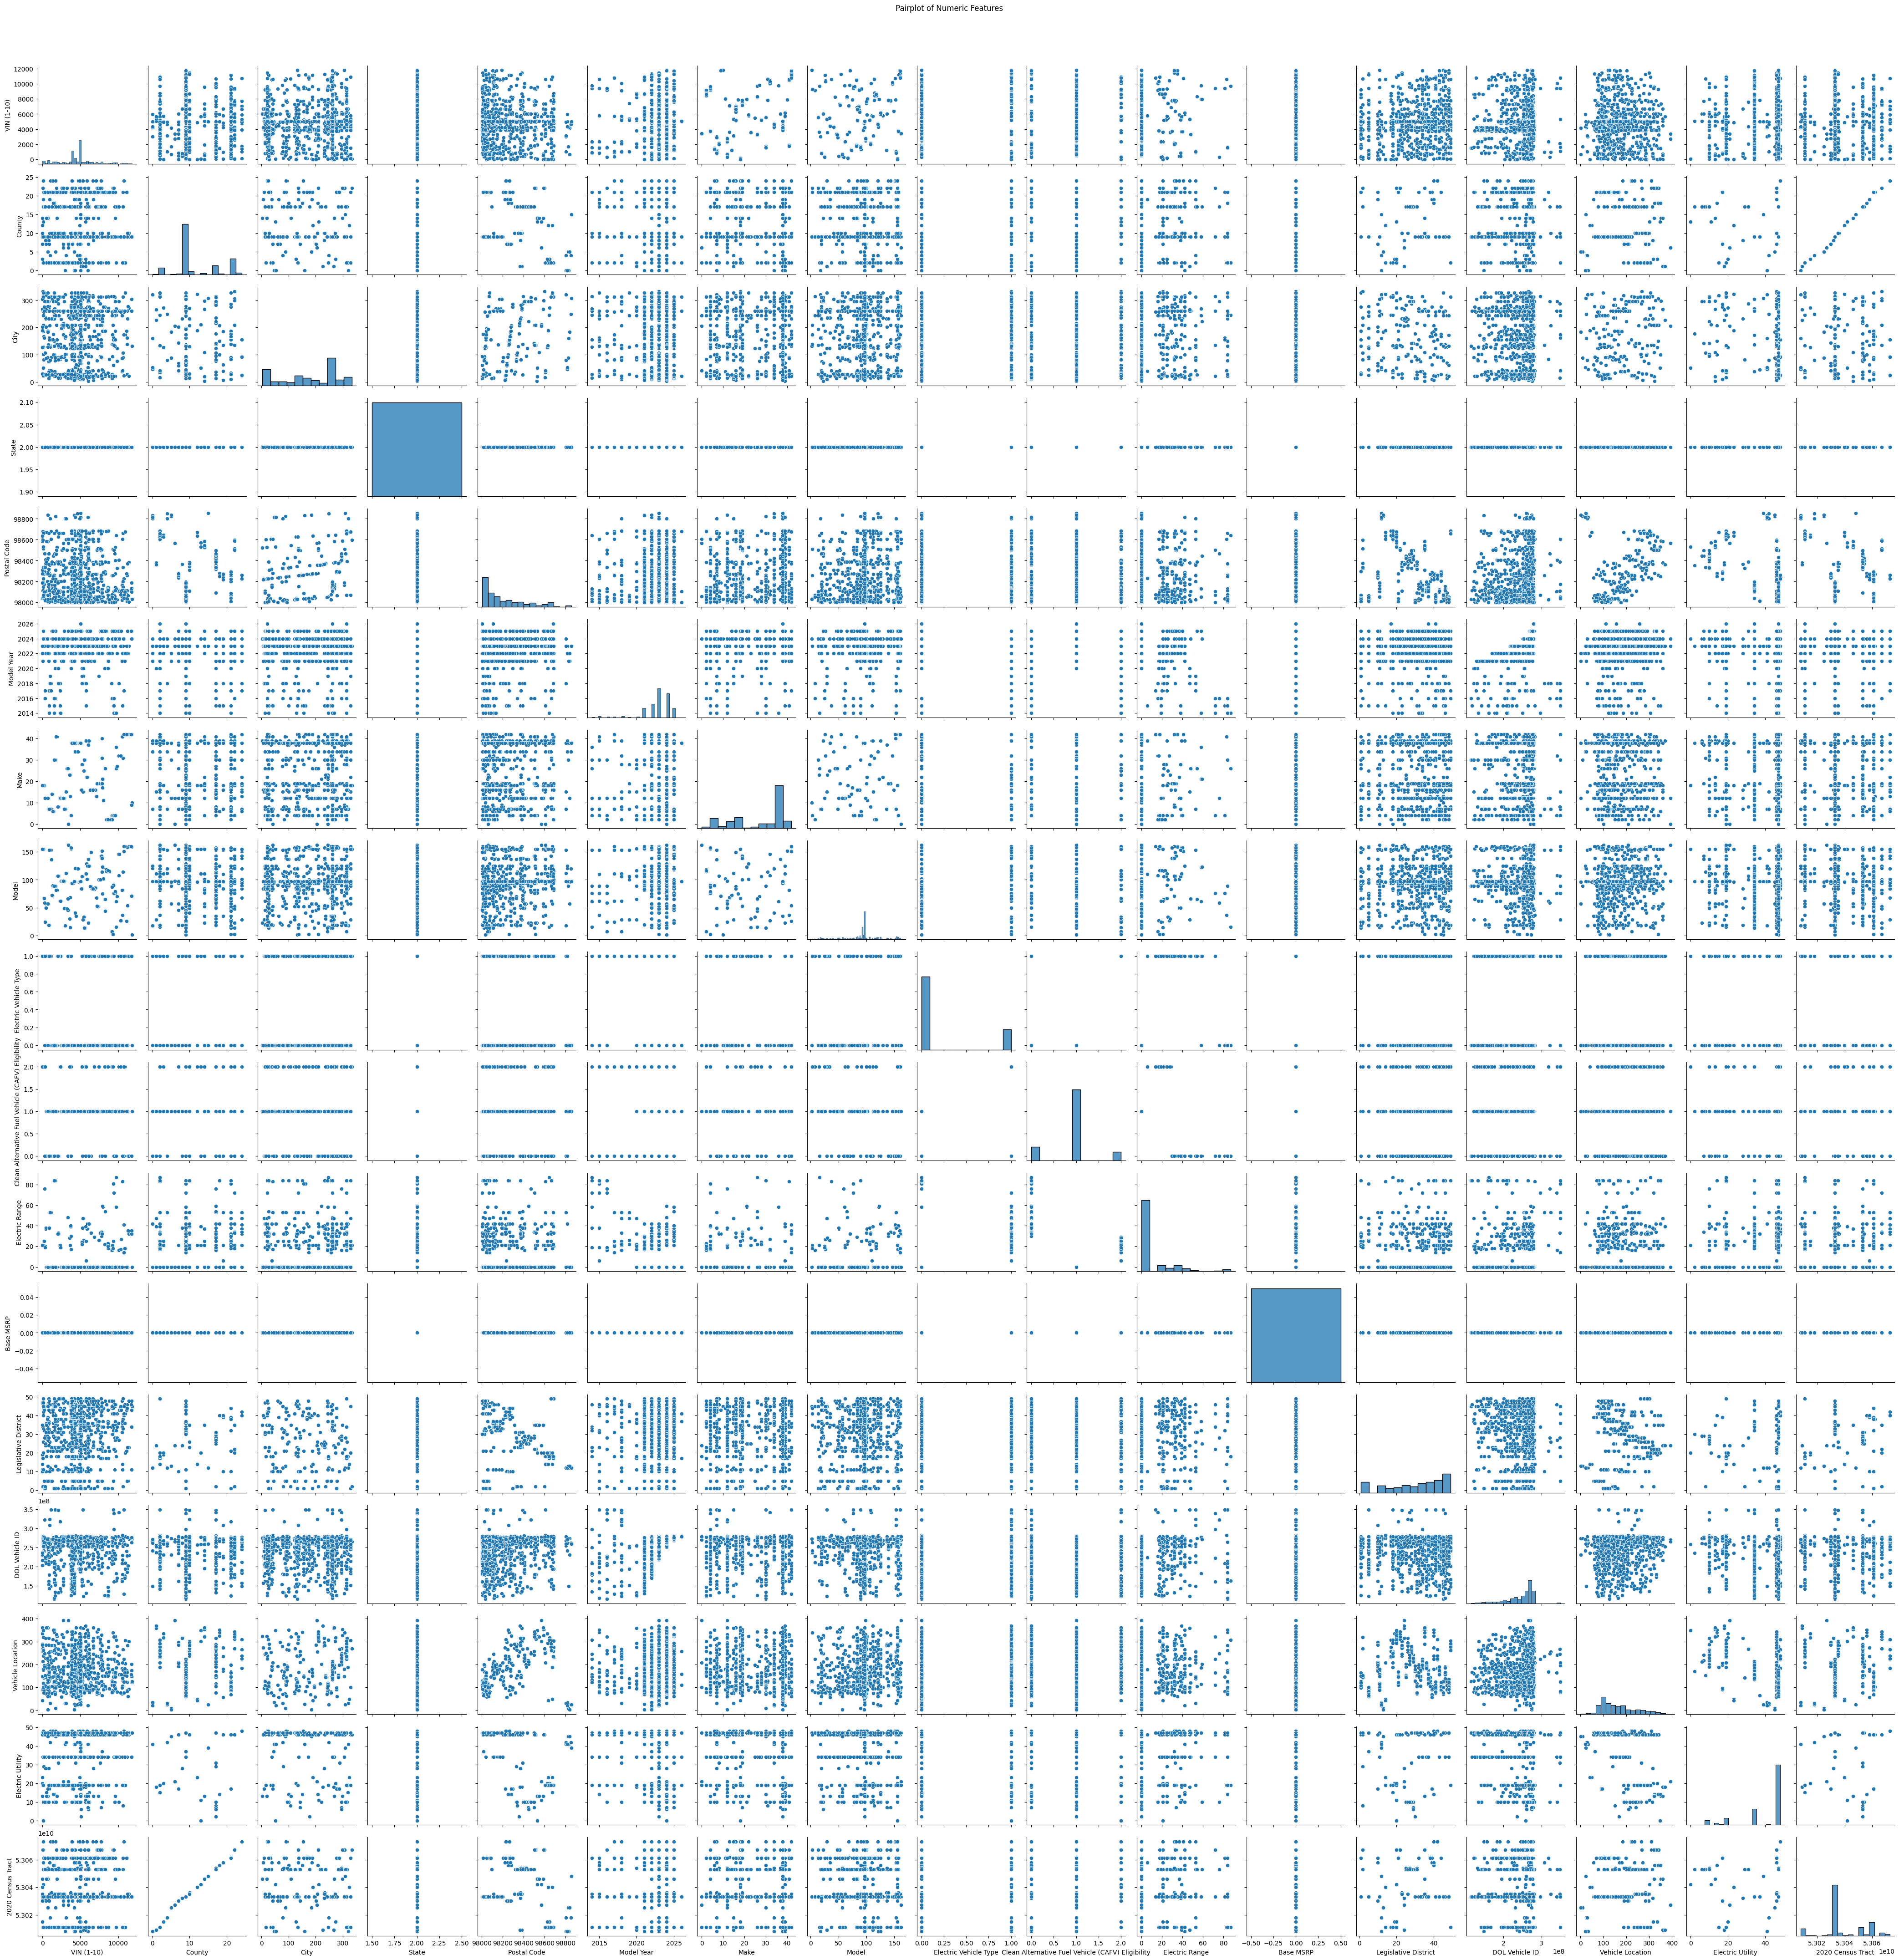

In [ ]:
# Pairplot of main variables (sample for large datasets)
sample_df = df.sample(min(1000, len(df)), random_state=42)
if len(num_cols) > 1:
    sns.pairplot(sample_df[num_cols])
    plt.suptitle('Pairplot of Numeric Features', y=1.02)
    plt.show()

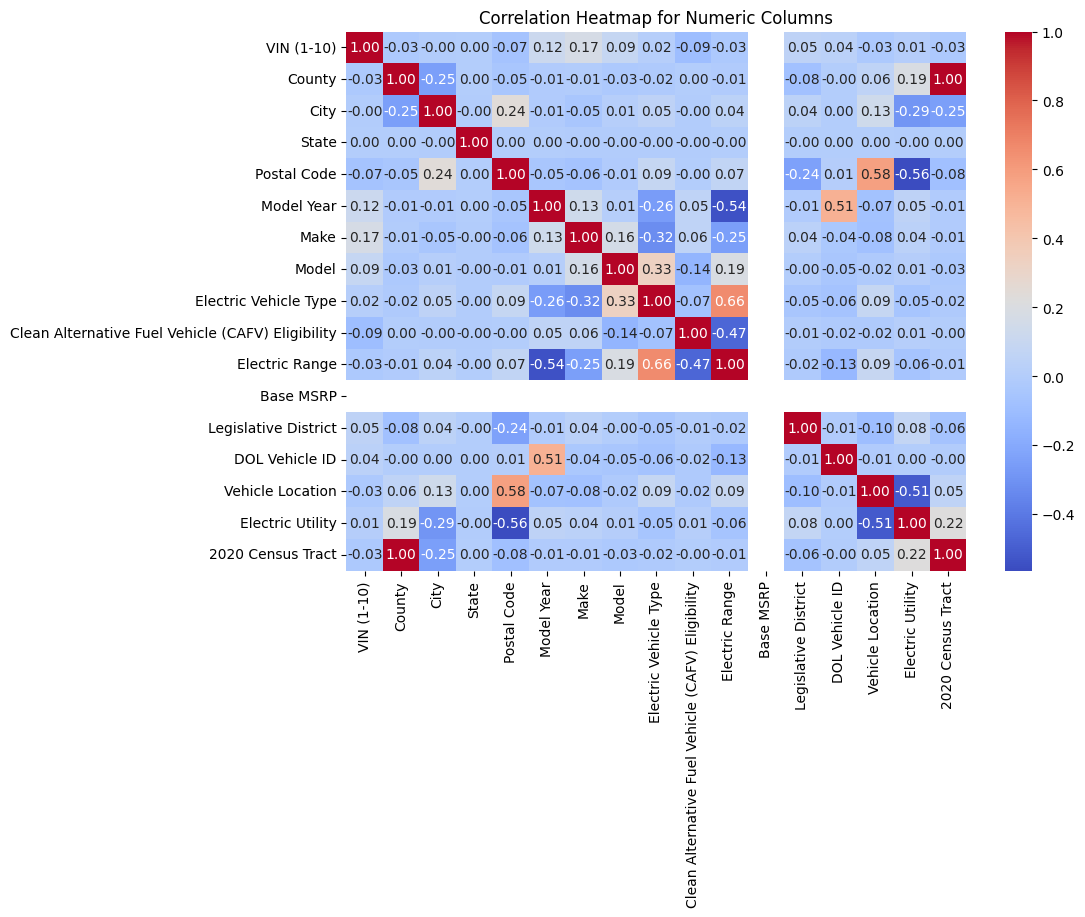

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is already loaded
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[num_cols].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap for Numeric Columns')
plt.show()

Top features: Index(['Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Vehicle_Age',
       'Model', 'Model Year', 'VIN (1-10)', 'Make', 'DOL Vehicle ID', 'City',
       'Postal Code'],
      dtype='object')


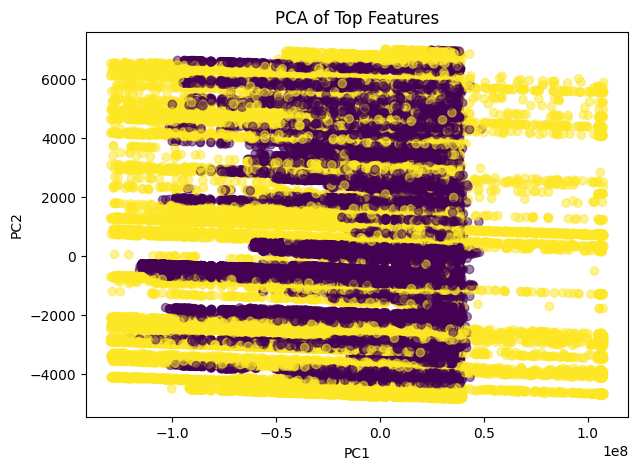

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Example new feature: Vehicle Age (if 'Model Year' exists)
if 'Model Year' in df.columns:
    df['Vehicle_Age'] = 2025 - df['Model Year']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Electric Range', axis=1))  # Assume Electric Range is your target

# Feature Selection (Random Forest importance)
y = (df['Electric Range'] > df['Electric Range'].median()).astype(int)  # Binary target
rf_fs = RandomForestClassifier(n_estimators=100, random_state=42)
rf_fs.fit(X_scaled, y)
importances = rf_fs.feature_importances_
top_idx = np.argsort(importances)[::-1][:10]
top_features = df.drop('Electric Range', axis=1).columns[top_idx]
print("Top features:", top_features)

# Feature extraction (PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df[top_features])

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', alpha=0.5)
plt.title("PCA of Top Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Subsample (optional, for balanced classes)
df_balanced = df.groupby(y).apply(lambda x: x.sample(min(len(x), 300), random_state=42)).reset_index(drop=True)
X = df_balanced[top_features]
y_bal = (df_balanced['Electric Range'] > df_balanced['Electric Range'].median()).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_bal, test_size=0.3, random_state=42, stratify=y_bal)


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.65      0.76      0.70        90
           1       0.71      0.60      0.65        90

    accuracy                           0.68       180
   macro avg       0.68      0.68      0.68       180
weighted avg       0.68      0.68      0.68       180

Confusion Matrix:
 [[68 22]
 [36 54]]
ROC-AUC: 0.7730864197530866


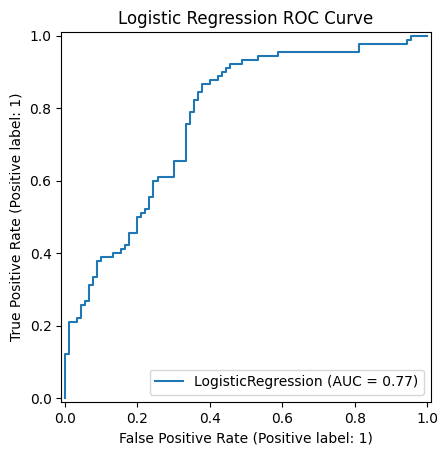


===== SVM =====
              precision    recall  f1-score   support

           0       0.52      0.92      0.66        90
           1       0.63      0.13      0.22        90

    accuracy                           0.53       180
   macro avg       0.57      0.53      0.44       180
weighted avg       0.57      0.53      0.44       180

Confusion Matrix:
 [[83  7]
 [78 12]]
ROC-AUC: 0.4274074074074074


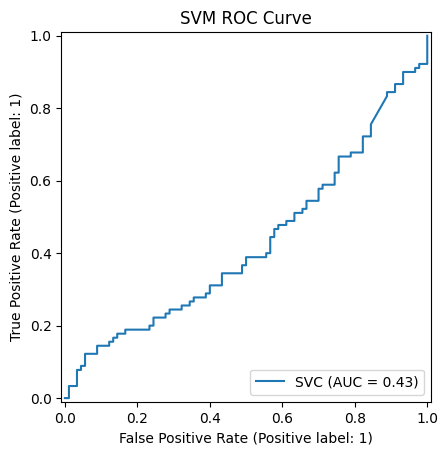


===== Gradient Boosting =====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

Confusion Matrix:
 [[90  0]
 [ 0 90]]
ROC-AUC: 1.0


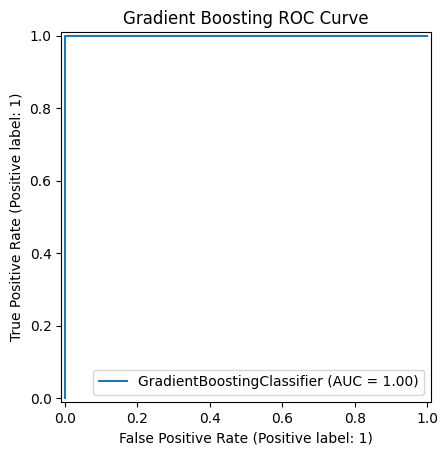


===== Naive Bayes =====
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        90
           1       0.68      0.56      0.61        90

    accuracy                           0.65       180
   macro avg       0.66      0.65      0.65       180
weighted avg       0.66      0.65      0.65       180

Confusion Matrix:
 [[67 23]
 [40 50]]
ROC-AUC: 0.7261728395061728


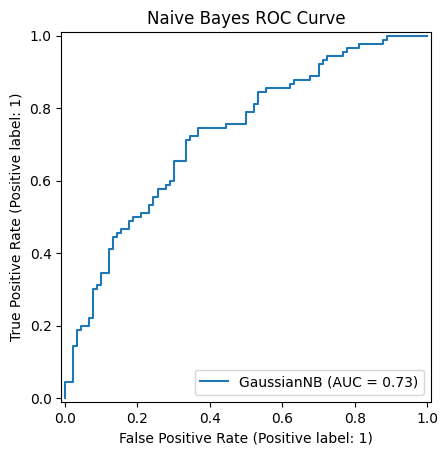

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Store models and results
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, penalty='l2', random_state=42),
    'SVM': SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'Naive Bayes': GaussianNB()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    # ROC-AUC and curve if possible
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, proba)
        print("ROC-AUC:", auc)
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title(f"{name} ROC Curve")
        plt.show()
    else:
        print("ROC-AUC not available for this model.")

In [ ]:
# Gradient Boosting with Binning
from sklearn.preprocessing import KBinsDiscretizer

binning = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_train_binned = binning.fit_transform(X_train)
X_test_binned = binning.transform(X_test)
gbc_bin = GradientBoostingClassifier()
gbc_bin.fit(X_train_binned, y_train)
y_pred_gbc_bin = gbc_bin.predict(X_test_binned)
print("Gradient Boosting (Optimal Binning) Results:\n", classification_report(y_test, y_pred_gbc_bin))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_gbc_bin))

Gradient Boosting (Optimal Binning) Results:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96        90
           1       0.96      0.97      0.96        90

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180

Confusion matrix:
 [[86  4]
 [ 3 87]]


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306

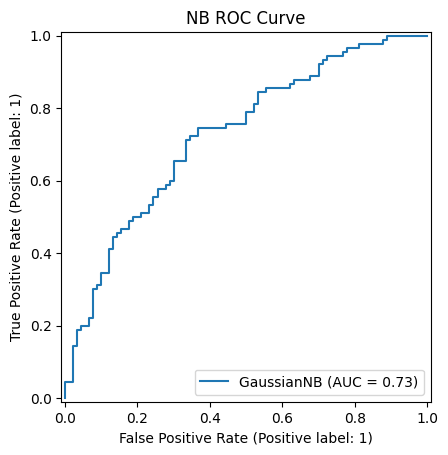

NB ROC-AUC: 0.7261728395061728


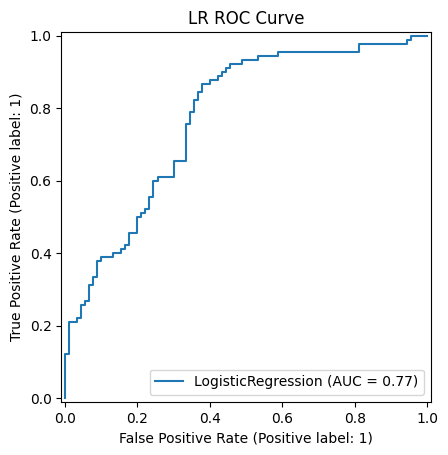

LR ROC-AUC: 0.7730864197530866


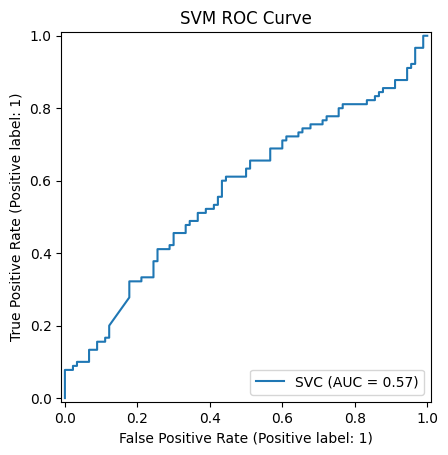

SVM ROC-AUC: 0.5724074074074075


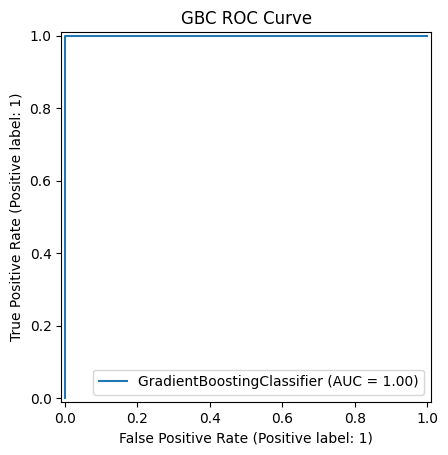

GBC ROC-AUC: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


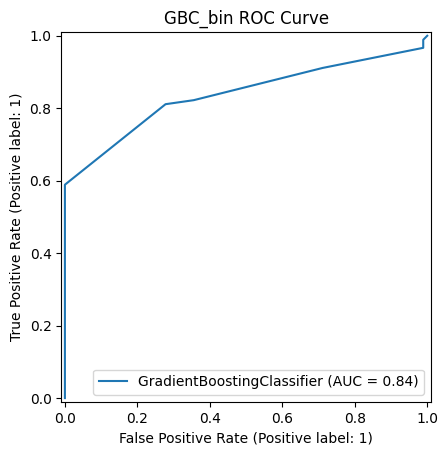

GBC_bin ROC-AUC: 0.837962962962963


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

models = {'NB': nb, 'LR': lr, 'SVM': svm, 'GBC': gbc, 'GBC_bin': gbc_bin}
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title(name + " ROC Curve")
        plt.show()
        print(f"{name} ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    elif hasattr(model, "decision_function"):
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title(name + " ROC Curve")
        plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Use a smaller subset for tuning (optional, but helps)
X_sample = X_train.sample(n=min(2000, len(X_train)), random_state=42)
y_sample = y_train.loc[X_sample.index]

# Parameter distributions
from scipy.stats import uniform, randint

param_dist_lr = {
    'C': uniform(0.01, 10),
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
param_dist_svm = {
    'C': uniform(0.1, 10),
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}
param_dist_gbc = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 7)
}
param_dist_nb = {}

n_iter_search = 10  # Try 10 random combinations per model

# Logistic Regression
rs_lr = RandomizedSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_distributions=param_dist_lr,
    n_iter=n_iter_search, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rs_lr.fit(X_sample, y_sample)
print("Best Logistic Regression params:", rs_lr.best_params_)

# SVM
rs_svm = RandomizedSearchCV(
    SVC(probability=True, random_state=42),
    param_distributions=param_dist_svm,
    n_iter=n_iter_search, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rs_svm.fit(X_sample, y_sample)
print("Best SVM params:", rs_svm.best_params_)

# Gradient Boosting
rs_gbc = RandomizedSearchCV(
    GradientBoostingClassifier(n_bins=5, encode='ordinal', strategy='quantile', random_state = 42),
    param_distributions=param_dist_gbc,
    n_iter=n_iter_search, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rs_gbc.fit(X_sample, y_sample)
print("Best Gradient Boosting params:", rs_gbc.best_params_)

# Naive Bayes (no real params, but for consistency)
rs_nb = RandomizedSearchCV(
    GaussianNB(), param_distributions=param_dist_nb,
    n_iter=1, cv=3, scoring='accuracy', random_state=42)
rs_nb.fit(X_sample, y_sample)

# Evaluate best estimators on full test set
print("LR Test Accuracy:", rs_lr.best_estimator_.score(X_test, y_test))
print("SVM Test Accuracy:", rs_svm.best_estimator_.score(X_test, y_test))
print("GBC Test Accuracy:", rs_gbc.best_estimator_.score(X_test, y_test))
print("NB Test Accuracy:", rs_nb.best_estimator_.score(X_test, y_test))

Best Logistic Regression params: {'C': np.float64(7.3299394181140505), 'penalty': 'l2', 'solver': 'lbfgs'}


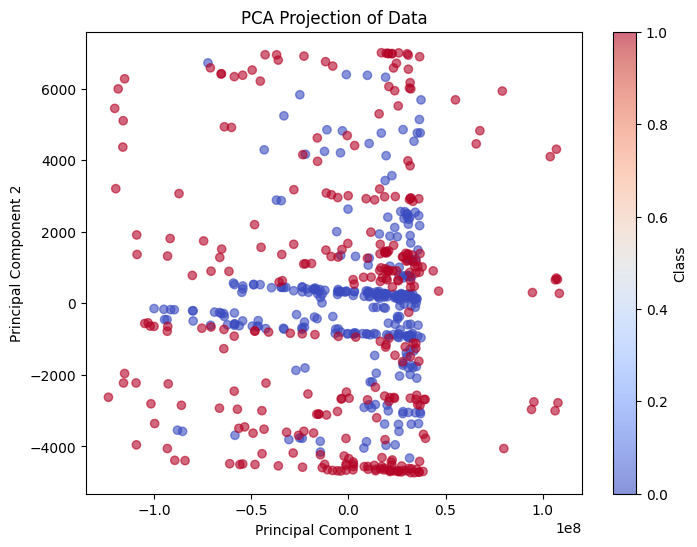

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_bal, cmap='coolwarm', alpha=0.6)
plt.title("PCA Projection of Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Class')
plt.show()

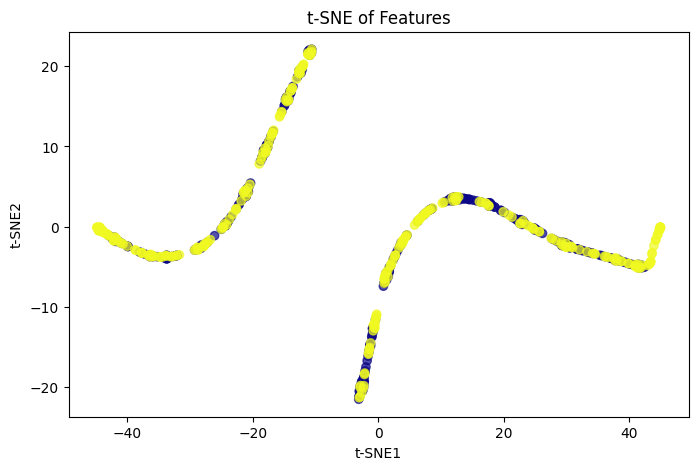

In [ ]:
from sklearn.manifold import TSNE

# t-SNE on top features
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8,5))
# Use y_bal for coloring as it corresponds to the subsampled data X
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_bal, cmap='plasma', alpha=0.7)
plt.title("t-SNE of Features")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.show()